In [287]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [288]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [289]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [290]:
def remove_unused_columns(df):
    df = df.drop(['wind_speed_10m:ms', 'elevation:m', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                 'wind_speed_w_1000hPa:ms'], axis=1)
    return df

In [291]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in train.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    for key in constanst_columns:
        if val.std()[key] != 0.0 or test.std()[key] != 0.0:
            constanst_columns.remove(key)

    for key in constanst_columns:
        train = train.drop([key], axis=1)
        val = val.drop([key], axis=1)
        test = test.drop([key], axis=1)

In [292]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60 #seconds in a day
    year = (365.2425)*day #seconds in a year
    month = year / 12.0

    date_time = pd.to_datetime(df.pop('date'), format='%Y-%m.%d %H:%M:%S')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    print(timestamp_s)

    #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))

In [293]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]
    df["is_in_shadow:idx"] = [round(df["is_in_shadow:idx"][i]) for i in range(len(df))]
    

In [294]:
def normalize_except_columns(df):
    not_to_be_norm = ["is_day:idx", "Year sin", "Year cos", 'is_in_shadow:idx', 'Hour sin', 'Hour cos']
    cols = df.columns.tolist()
    cols_to_norm = [i for i in cols if i not in not_to_be_norm]
    
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


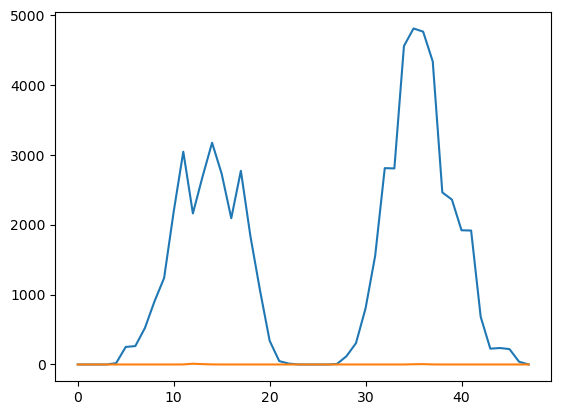

In [295]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

plt.plot(train_a["pv_measurement"][0:24 * 2])
plt.plot(train_b["pv_measurement"][0:24 * 2])
plt.plot(train_c["pv_measurement"][0:24 * 2])

In [296]:
a_max = train_a["pv_measurement"].max()
b_max = train_b["pv_measurement"].max()
c_max = train_c["pv_measurement"].max()

In [297]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [298]:
# Join data and labels into one df
train_data_a, val_data_a = join_data_and_labels(X_train_observed_a, X_train_estimated_a, train_a)
train_data_b, val_data_b = join_data_and_labels(X_train_observed_b, X_train_estimated_b, train_b)
train_data_c, val_data_c = join_data_and_labels(X_train_observed_c, X_train_estimated_c, train_c)

In [299]:
# Remove columns which are not needed
train_data_a = remove_unused_columns(train_data_a)
val_data_a = remove_unused_columns(val_data_a)
test_a = remove_unused_columns(test_a)

train_data_b = remove_unused_columns(train_data_b)
val_data_b = remove_unused_columns(val_data_b)
test_b = remove_unused_columns(test_b)

train_data_c = remove_unused_columns(train_data_c)
val_data_c = remove_unused_columns(val_data_c)
test_c = remove_unused_columns(test_c)

In [300]:
# Drop columns which are constant
drop_constanst_columns(train_data_a, val_data_a, test_a)
drop_constanst_columns(train_data_b, val_data_b, test_b)
drop_constanst_columns(train_data_c, val_data_c, test_c)

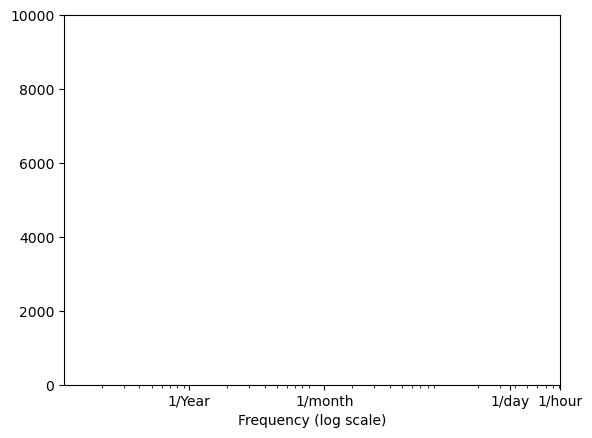

In [301]:
fft = tf.signal.rfft(train_data_b['pv_measurement'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(train_data_b['pv_measurement'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524, 12, 365.2524 * 2.5,], labels=['1/Year', '1/day', '1/month', '1/hour'])
_ = plt.xlabel('Frequency (log scale)')

In [302]:
# Convert date into sin and cos components
convert_date_to_sin_and_cos(train_data_a)
convert_date_to_sin_and_cos(val_data_a)
convert_date_to_sin_and_cos(test_a)

convert_date_to_sin_and_cos(train_data_b)
convert_date_to_sin_and_cos(val_data_b)
convert_date_to_sin_and_cos(test_b)

convert_date_to_sin_and_cos(train_data_c)
convert_date_to_sin_and_cos(val_data_c)
convert_date_to_sin_and_cos(test_c)

0        1.559513e+09
1        1.559516e+09
2        1.559520e+09
3        1.559524e+09
4        1.559527e+09
             ...     
29662    1.666296e+09
29663    1.666300e+09
29664    1.666303e+09
29665    1.666307e+09
29666    1.666310e+09
Name: date, Length: 29667, dtype: float64
0       1.666994e+09
1       1.666998e+09
2       1.667002e+09
3       1.667005e+09
4       1.667009e+09
            ...     
4389    1.682881e+09
4390    1.682885e+09
4391    1.682888e+09
4392    1.682892e+09
4393    1.682896e+09
Name: date, Length: 4394, dtype: float64
0      1.682901e+09
1      1.682904e+09
2      1.682908e+09
3      1.682911e+09
4      1.682915e+09
           ...     
715    1.688412e+09
716    1.688416e+09
717    1.688419e+09
718    1.688423e+09
719    1.688427e+09
Name: date, Length: 720, dtype: float64
0        1.546301e+09
1        1.546304e+09
2        1.546308e+09
3        1.546312e+09
4        1.546315e+09
             ...     
29217    1.651518e+09
29218    1.651522e+09
29219   

In [303]:
# Isday should be a binary value
round_is_day(train_data_a)
round_is_day(val_data_a)
round_is_day(test_a)

round_is_day(train_data_b)
round_is_day(val_data_b)
round_is_day(test_b)

round_is_day(train_data_c)
round_is_day(val_data_c)
round_is_day(test_c)

In [304]:
normalize_except_columns(train_data_a)
normalize_except_columns(val_data_a)
normalize_except_columns(test_a)

normalize_except_columns(train_data_b)
normalize_except_columns(val_data_b)
normalize_except_columns(test_b)

normalize_except_columns(train_data_c)
normalize_except_columns(val_data_c)
normalize_except_columns(test_c)

In [305]:
# Fill 0 for NaNs
train_data_a = train_data_a.fillna(0)
val_data_a = val_data_a.fillna(0)
test_a = test_a.fillna(0)

train_data_b = train_data_b.fillna(0)
val_data_b = val_data_b.fillna(0)
test_b = test_b.fillna(0)

train_data_c = train_data_c.fillna(0)
val_data_c = val_data_c.fillna(0)
test_c = test_c.fillna(0)

In [306]:
b = 60
print(len(train_data_a) / b)
print(len(val_data_a) / b)
print(len(test_a) / b)

494.45
73.23333333333333
12.0


In [332]:
MAX_EPOCHS = 20

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=4,
                                                    mode='min',
                                                    restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.RMSprop(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [308]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=60

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [309]:
def batch(df):
    BATCH_SIZE=60

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [310]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [333]:
lstm_model_a = tf.keras.models.Sequential([   
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(60, return_sequences=True, kernel_initializer='random_uniform',
                    bias_initializer='zeros')
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.5)
    ),
    #tf.keras.layers.LSTM(64, return_sequences=True),
    #tf.keras.layers.Dense(units=48),
    #tf.keras.layers.Dense(units=32),

    tf.keras.layers.Dense(units=1, activation="relu")
])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [334]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.006232030689716339, 0.03161332383751869]
#[0.005147780757397413, 0.028607070446014404] -> year and day
#[0.004300971981137991, 0.02555842511355877]

Epoch 1/20
16/16 [==============================] - 15s 259ms/step - loss: 0.0553 - mean_absolute_error: 0.1124 - val_loss: 0.0078 - val_mean_absolute_error: 0.0335
Epoch 2/20
16/16 [==============================] - 2s 110ms/step - loss: 0.0123 - mean_absolute_error: 0.0557 - val_loss: 0.0107 - val_mean_absolute_error: 0.0394
Epoch 3/20
16/16 [==============================] - 2s 111ms/step - loss: 0.0113 - mean_absolute_error: 0.0529 - val_loss: 0.0058 - val_mean_absolute_error: 0.0321
Epoch 4/20
16/16 [==============================] - 2s 111ms/step - loss: 0.0127 - mean_absolute_error: 0.0566 - val_loss: 0.0055 - val_mean_absolute_error: 0.0309
Epoch 5/20
16/16 [==============================] - 2s 111ms/step - loss: 0.0096 - mean_absolute_error: 0.0482 - val_loss: 0.0050 - val_mean_absolute_error: 0.0288
Epoch 6/20
16/16 [==============================] - 2s 111ms/step - loss: 0.0099 - mean_absolute_error: 0.0485 - val_loss: 0.0054 - val_mean_absolute_error: 0.0306
Epoch 7/20
16/1

In [335]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

#[0.007145202253013849, 0.03178989142179489]
#[0.008217844180762768, 0.03327266126871109]
#[0.0067342291586101055, 0.030065299943089485]

Epoch 1/20
16/16 [==============================] - 16s 254ms/step - loss: 0.0286 - mean_absolute_error: 0.0800 - val_loss: 0.0097 - val_mean_absolute_error: 0.0337
Epoch 2/20
16/16 [==============================] - 2s 117ms/step - loss: 0.0102 - mean_absolute_error: 0.0503 - val_loss: 0.0053 - val_mean_absolute_error: 0.0275
Epoch 3/20
16/16 [==============================] - 2s 116ms/step - loss: 0.0106 - mean_absolute_error: 0.0508 - val_loss: 0.0065 - val_mean_absolute_error: 0.0293
Epoch 4/20
16/16 [==============================] - 2s 118ms/step - loss: 0.0098 - mean_absolute_error: 0.0479 - val_loss: 0.0046 - val_mean_absolute_error: 0.0253
Epoch 5/20
16/16 [==============================] - 2s 117ms/step - loss: 0.0085 - mean_absolute_error: 0.0447 - val_loss: 0.0073 - val_mean_absolute_error: 0.0312
Epoch 6/20
16/16 [==============================] - 2s 118ms/step - loss: 0.0099 - mean_absolute_error: 0.0482 - val_loss: 0.0045 - val_mean_absolute_error: 0.0252
Epoch 7/20
16/1

In [336]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.004318469204008579, 0.02518327347934246]
#[0.004314047750085592, 0.025382312014698982]
#[0.003403852926567197, 0.02470281533896923]

Epoch 1/20
16/16 [==============================] - 17s 255ms/step - loss: 0.0290 - mean_absolute_error: 0.0695 - val_loss: 0.0163 - val_mean_absolute_error: 0.0454
Epoch 2/20
16/16 [==============================] - 2s 115ms/step - loss: 0.0287 - mean_absolute_error: 0.0653 - val_loss: 0.0163 - val_mean_absolute_error: 0.0454
Epoch 3/20
16/16 [==============================] - 2s 115ms/step - loss: 0.0287 - mean_absolute_error: 0.0653 - val_loss: 0.0163 - val_mean_absolute_error: 0.0454
Epoch 4/20
16/16 [==============================] - 2s 114ms/step - loss: 0.0287 - mean_absolute_error: 0.0653 - val_loss: 0.0163 - val_mean_absolute_error: 0.0454
Epoch 5/20
16/16 [==============================] - 2s 115ms/step - loss: 0.0325 - mean_absolute_error: 0.0794 - val_loss: 0.0060 - val_mean_absolute_error: 0.0283
Epoch 6/20
16/16 [==============================] - 2s 116ms/step - loss: 0.0119 - mean_absolute_error: 0.0495 - val_loss: 0.0039 - val_mean_absolute_error: 0.0262
Epoch 7/20
16/1

In [337]:
#lstm_model_a.get_weight_paths()

In [338]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

2/2 [==============================] - 0s 44ms/step


In [339]:
pred_a = pred_a.flatten() * a_max
pred_b = pred_b.flatten() * b_max
pred_c = pred_c.flatten() * c_max

pred_a_val = pred_a_val.flatten() * a_max
pred_b_val = pred_b_val.flatten() * b_max
pred_c_val = pred_c_val.flatten() * c_max

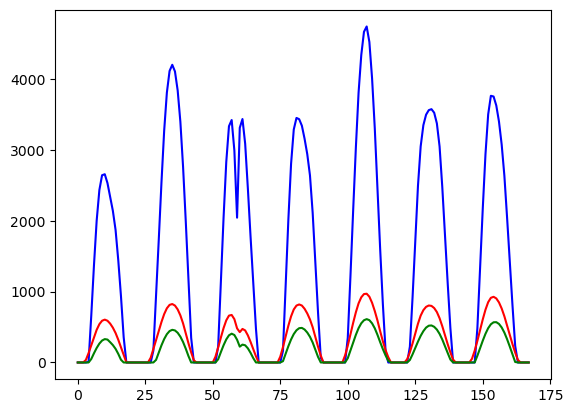

In [342]:
plt.plot(pred_a[0:24*7], color="blue")
plt.plot(pred_b[0:24*7], color="red")
plt.plot(pred_c[0:24*7], color="green")

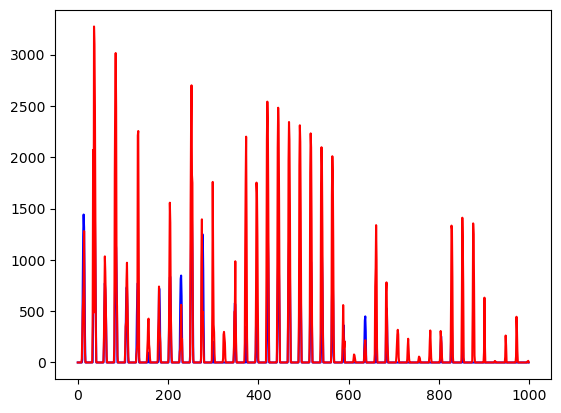

In [341]:
plt.plot(pred_a_val[:1000], color="blue")
plt.plot(val_a_y.flatten()[:1000] * a_max, color="red")

In [243]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [244]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [245]:
submit = np.concatenate((np.concatenate((pred_a, pred_b)),pred_c))

In [246]:
from datetime import datetime

now = datetime.now() # current date and time

# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("bi_vol2.csv", index=False)